In [1]:
# =============================================================================
# Train: Fuse saved GFT (DINOv2+GALA+PPS) with CoAtNet and fine-tune the fusion
# =============================================================================
import os
import math
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from transformers import AutoModel, AutoImageProcessor
import timm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# 0. CONFIG
# =============================================================================
class Config:
    # dataset
    BASE_DIR = r"A:\journal V2\melspectrograms_dataset"   # <--- set your dataset base dir
    IMG_SIZE = 224
    BATCH_SIZE = 16      # reduce if OOM
    NUM_WORKERS = 0

    # model / checkpoints
    GFT_MODEL_PATH = r"A:\journal V2\gft\best_full_gft_gala_pps.pth"  # <--- path to your saved GFT model
    COATNET_MODEL = "coatnet_0_rw_224"   # timm model name; change if you prefer other CoAtNet variants
    PRETRAINED_COATNET = True
    SAVE_DIR = r"A:\journal V2\checkpoints_fusion"
    os.makedirs(SAVE_DIR, exist_ok=True)

    # training phases and hyperparams
    HEAD_EPOCHS = 8
    PARTIAL_EPOCHS = 30
    FULL_EPOCHS = 20

    HEAD_LR = 3e-4
    PARTIAL_LR = 5e-5
    FULL_LR = 5e-6
    WEIGHT_DECAY = 0.05
    LR_WARMUP_EPOCHS = 3
    PATIENCE = 12

    # augment/reg
    MIXUP_ALPHA = 0.4
    SPEC_AUG_FREQ = 25
    SPEC_AUG_TIME = 40
    DROP_RATE = 0.4

    # device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print("Device:", config.DEVICE)
print("Loading GFT checkpoint from:", config.GFT_MODEL_PATH)


Device: cuda
Loading GFT checkpoint from: A:\journal V2\gft\best_full_gft_gala_pps.pth


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Found 4021 images in train with 6 classes.
Found 73 images in validation with 6 classes.
Num classes: 6
Loading GFT checkpoint into gft_branch (strict=False)...
Loaded checkpoint (strict=False).
Creating CoAtNet (coatnet_0_rw_224, pretrained=True)
Fusion model created and moved to device.

HEAD PHASE - Epoch 1/8


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0867 Acc 0.8724 | Val Loss 0.0962 Acc 0.8630
Saved best head model.

HEAD PHASE - Epoch 2/8


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0604 Acc 0.8846 | Val Loss 0.1281 Acc 0.7808

HEAD PHASE - Epoch 3/8


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0570 Acc 0.8936 | Val Loss 0.1338 Acc 0.8356

HEAD PHASE - Epoch 4/8


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0539 Acc 0.8928 | Val Loss 0.1320 Acc 0.7945

HEAD PHASE - Epoch 5/8


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0517 Acc 0.8963 | Val Loss 0.1258 Acc 0.8219

HEAD PHASE - Epoch 6/8


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0493 Acc 0.9028 | Val Loss 0.1253 Acc 0.8082

HEAD PHASE - Epoch 7/8


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0486 Acc 0.9015 | Val Loss 0.1307 Acc 0.8219

HEAD PHASE - Epoch 8/8


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.0518 Acc 0.8886 | Val Loss 0.1139 Acc 0.8630

Partial unfreeze: unfreeze coatnet last layers and last GFT stage

PARTIAL PHASE - Epoch 1/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1971 Acc 0.5379 | Val Loss 0.1202 Acc 0.8219

PARTIAL PHASE - Epoch 2/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1794 Acc 0.5678 | Val Loss 0.1108 Acc 0.8219

PARTIAL PHASE - Epoch 3/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1786 Acc 0.5519 | Val Loss 0.1150 Acc 0.8082

PARTIAL PHASE - Epoch 4/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1825 Acc 0.5571 | Val Loss 0.1127 Acc 0.8356

PARTIAL PHASE - Epoch 5/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1853 Acc 0.5558 | Val Loss 0.1130 Acc 0.8356

PARTIAL PHASE - Epoch 6/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1834 Acc 0.5404 | Val Loss 0.1238 Acc 0.8356

PARTIAL PHASE - Epoch 7/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1936 Acc 0.5359 | Val Loss 0.1062 Acc 0.8493

PARTIAL PHASE - Epoch 8/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1758 Acc 0.5280 | Val Loss 0.1200 Acc 0.7671

PARTIAL PHASE - Epoch 9/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1692 Acc 0.5675 | Val Loss 0.1053 Acc 0.8356

PARTIAL PHASE - Epoch 10/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1779 Acc 0.5608 | Val Loss 0.1014 Acc 0.8219

PARTIAL PHASE - Epoch 11/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1660 Acc 0.5143 | Val Loss 0.1113 Acc 0.8219

PARTIAL PHASE - Epoch 12/30


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1745 Acc 0.5456 | Val Loss 0.1005 Acc 0.8493
Early stopping (partial) triggered.

FULL FINETUNE - Unfreezing all parameters

FULL PHASE - Epoch 1/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1729 Acc 0.5685 | Val Loss 0.1085 Acc 0.8356

FULL PHASE - Epoch 2/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1528 Acc 0.5491 | Val Loss 0.1375 Acc 0.7671

FULL PHASE - Epoch 3/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1590 Acc 0.5484 | Val Loss 0.1512 Acc 0.7945

FULL PHASE - Epoch 4/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1613 Acc 0.5847 | Val Loss 0.1243 Acc 0.8767
Saved best full fusion model.

FULL PHASE - Epoch 5/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1533 Acc 0.5986 | Val Loss 0.1455 Acc 0.7534

FULL PHASE - Epoch 6/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1624 Acc 0.5678 | Val Loss 0.1390 Acc 0.8219

FULL PHASE - Epoch 7/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1578 Acc 0.5593 | Val Loss 0.1420 Acc 0.8356

FULL PHASE - Epoch 8/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1479 Acc 0.5531 | Val Loss 0.1325 Acc 0.8356

FULL PHASE - Epoch 9/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1538 Acc 0.5790 | Val Loss 0.1425 Acc 0.8082

FULL PHASE - Epoch 10/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1431 Acc 0.5098 | Val Loss 0.1235 Acc 0.8356

FULL PHASE - Epoch 11/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1522 Acc 0.5802 | Val Loss 0.1253 Acc 0.8082

FULL PHASE - Epoch 12/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1346 Acc 0.5760 | Val Loss 0.1253 Acc 0.8493

FULL PHASE - Epoch 13/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1405 Acc 0.5924 | Val Loss 0.1229 Acc 0.8356

FULL PHASE - Epoch 14/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1520 Acc 0.6260 | Val Loss 0.1256 Acc 0.8356

FULL PHASE - Epoch 15/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1521 Acc 0.5511 | Val Loss 0.1244 Acc 0.8493

FULL PHASE - Epoch 16/20


Train:   0%|          | 0/252 [00:00<?, ?it/s]

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss 0.1425 Acc 0.5685 | Val Loss 0.1233 Acc 0.8493
Early stopping (full) triggered.


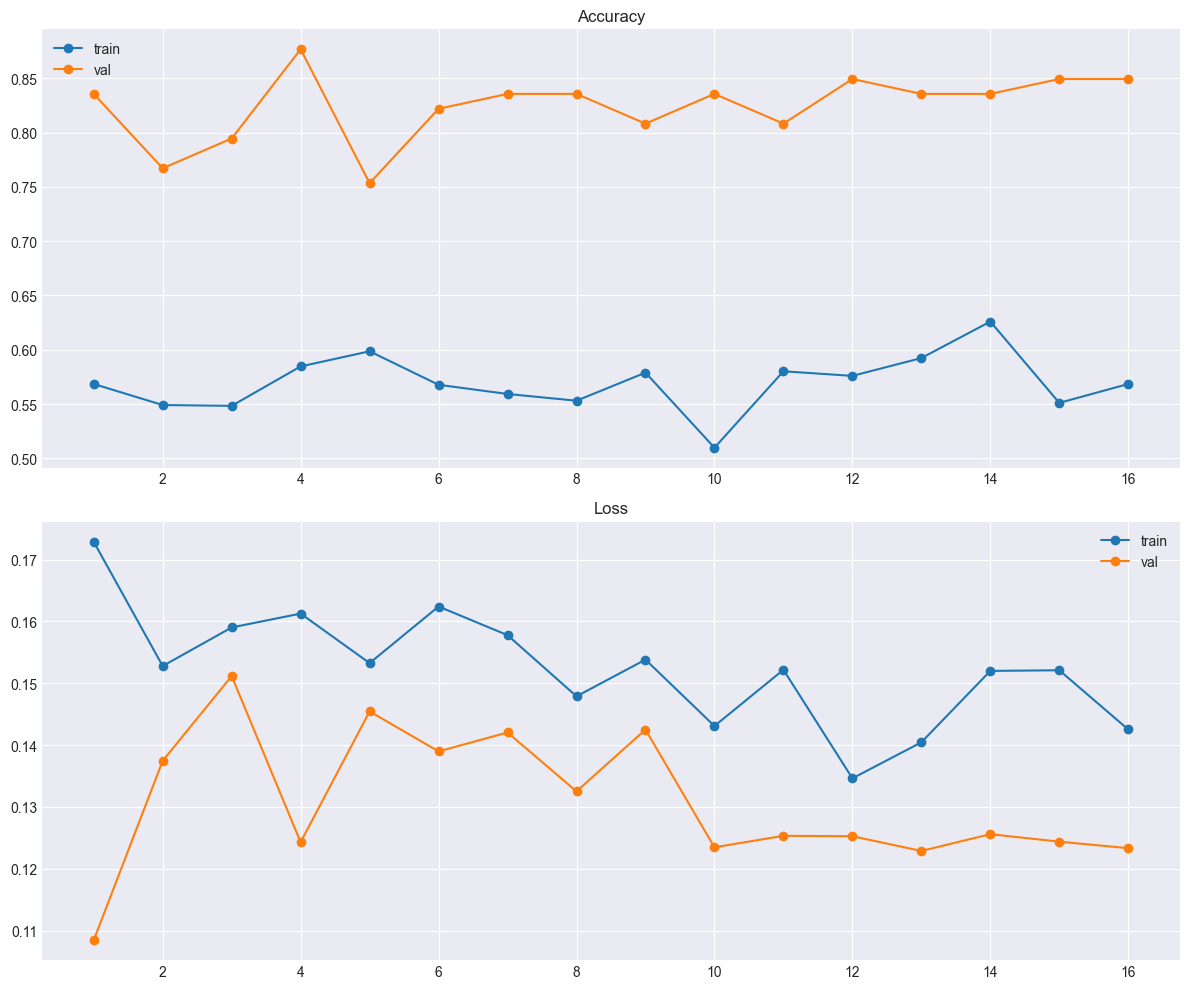


Final evaluation - Fusion model


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Found 74 images in test with 6 classes.
Loading GFT checkpoint into gft_branch (strict=False)...
Loaded checkpoint (strict=False).
Creating CoAtNet (coatnet_0_rw_224, pretrained=True)


Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 0.8378 (83.78%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6154    0.6154    0.6154        13
           Laryngozele     0.8000    0.8889    0.8421         9
           Vox senilis     0.7857    0.8462    0.8148        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8182    0.6923    0.7500        13

              accuracy                         0.8378        74
             macro avg     0.8365    0.8405    0.8371        74
          weighted avg     0.8385    0.8378    0.8368        74



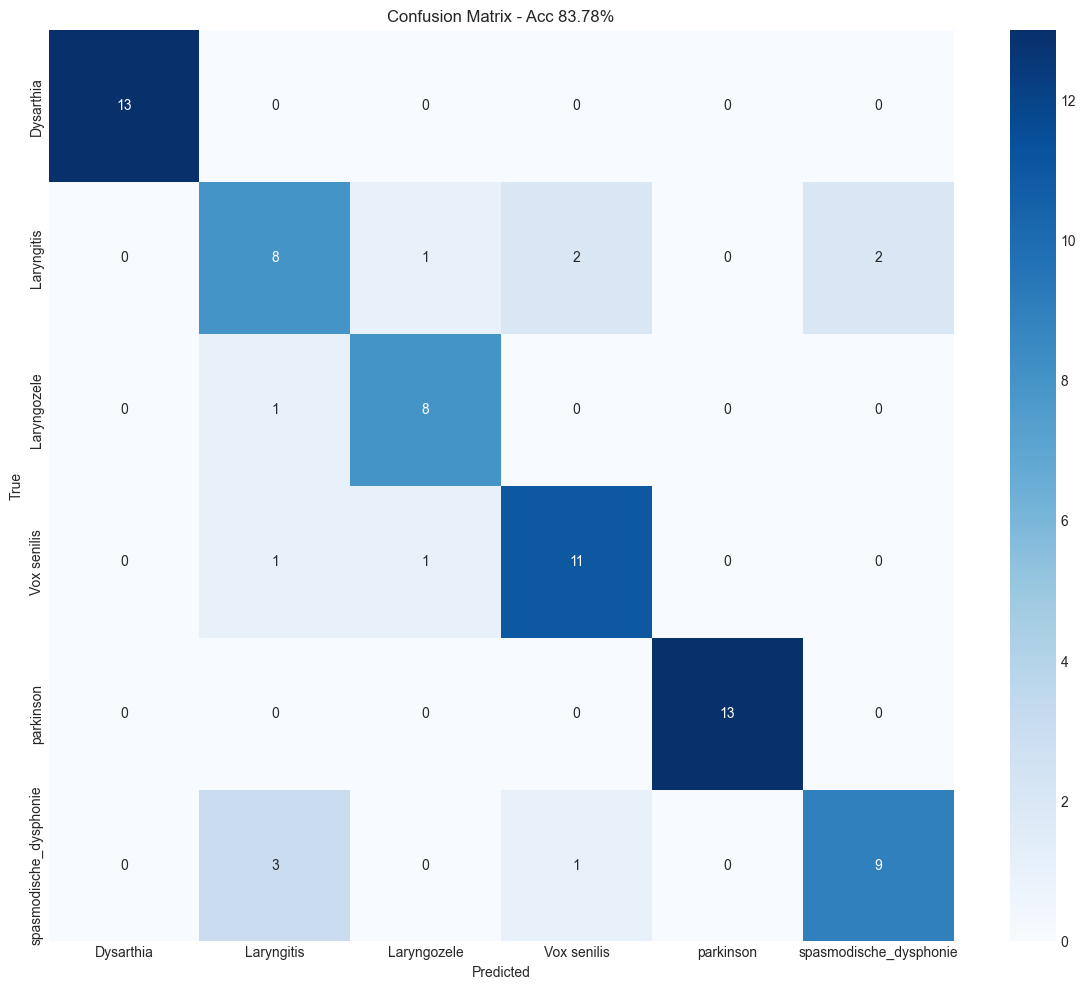

In [2]:

# =============================================================================
# 1. LOSS: Gradient Focal Loss (same as before)
# =============================================================================
class GradientFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, reduction="none")
        p = torch.exp(-ce)
        probs = torch.softmax(logits, dim=1)
        target_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        grad_weight = torch.abs(target_probs - 1.0)
        focal = self.alpha * (1 - p) ** self.gamma * (1 + grad_weight)
        loss = focal * ce
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# =============================================================================
# 2. (Minimal) GFT modules needed to load the saved checkpoint
#    NOTE: these are kept compact; we don't re-implement full two-pass GALA here.
# =============================================================================
class GALA_Attention(nn.Module):
    def __init__(self, dim, n_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.focal_gamma = nn.Parameter(torch.ones(n_heads, 1, 1))
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn_weights = torch.softmax(attn, dim=-1)
        focal = torch.pow(1.0 - attn_weights, self.focal_gamma)
        attn = attn_weights * focal
        attn = attn / (attn.sum(dim=-1, keepdim=True) + 1e-6)
        out = (self.attn_drop(attn) @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj_drop(self.proj(out))

class GFT_Encoder_Minimal(nn.Module):
    def __init__(self, embed_dim, num_stages=3, n_heads=6, drop_rate=0.3):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(embed_dim),
                GALA_Attention(embed_dim, n_heads=n_heads,
                               attn_drop=drop_rate*0.5, proj_drop=drop_rate*0.5),
                nn.LayerNorm(embed_dim),
                nn.Linear(embed_dim, embed_dim),
                nn.GELU(),
                nn.Dropout(drop_rate)
            ) for _ in range(num_stages)
        ])
    def forward(self, x):
        for stage in self.stages:
            x = stage(x)
        return x

# Minimal wrapper model to load the GFT checkpoint into
class DinoV2_GFT_Minimal(nn.Module):
    def __init__(self, model_name, num_classes, gft_stages=3, n_heads=6, drop_rate=0.3):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        embed_dim = self.backbone.config.hidden_size
        self.embed_dim = embed_dim
        self.gft_encoder = GFT_Encoder_Minimal(embed_dim, num_stages=gft_stages, n_heads=n_heads, drop_rate=drop_rate)
        self.pool_norm = nn.LayerNorm(embed_dim)
        # classifier head (may differ from checkpoint; load with strict=False)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(drop_rate*0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, pixel_values, token_mask=None):
        outputs = self.backbone(pixel_values=pixel_values)
        tokens = outputs.last_hidden_state
        if token_mask is not None:
            tokens = tokens * token_mask.unsqueeze(-1)
        features = self.gft_encoder(tokens)
        pooled = torch.mean(features, dim=1)
        pooled = self.pool_norm(pooled)
        logits = self.classifier(pooled)
        return logits

# =============================================================================
# 3. Fusion model: loads GFT checkpoint into the gft_branch, and builds CoAtNet branch
# =============================================================================
class GFT_CoAtNet_Fusion(nn.Module):
    def __init__(self, gft_checkpoint_path, num_classes, coatnet_name="coatnet_0_rw_224", coatnet_pretrained=True,
                 gft_model_name="facebook/dinov2-small", gft_stages=3, gft_heads=6, drop_rate=0.3):
        super().__init__()
        # build the GFT branch (architecture should match the saved GFT structure sufficiently)
        self.gft_branch = DinoV2_GFT_Minimal(gft_model_name, num_classes, gft_stages=gft_stages,
                                             n_heads=gft_heads, drop_rate=drop_rate)

        # load weights from saved GFT checkpoint into gft_branch
        if gft_checkpoint_path and os.path.exists(gft_checkpoint_path):
            print("Loading GFT checkpoint into gft_branch (strict=False)...")
            state = torch.load(gft_checkpoint_path, map_location="cpu")
            # attempt to load top-level if checkpoint matches
            try:
                self.gft_branch.load_state_dict(state, strict=False)
                print("Loaded checkpoint (strict=False).")
            except Exception as e:
                # if state is dict with keys like 'model_state_dict' or nested, try to smartly extract
                if isinstance(state, dict):
                    # common key names:
                    possible_keys = ["state_dict", "model_state_dict", "model"]
                    found = False
                    for k in possible_keys:
                        if k in state and isinstance(state[k], dict):
                            self.gft_branch.load_state_dict(state[k], strict=False)
                            print(f"Loaded state from checkpoint['{k}'] (strict=False).")
                            found = True
                            break
                    if not found:
                        # try partial load: match keys
                        sd = state if all(isinstance(v, torch.Tensor) for v in state.values()) else state.get("state_dict", state)
                        if isinstance(sd, dict):
                            self.gft_branch.load_state_dict(sd, strict=False)
                            print("Attempted partial load from checkpoint dict (strict=False).")
                        else:
                            print("Warning: checkpoint format not recognized; gft_branch init with pretrained HF weights only.")
                else:
                    print("Warning: checkpoint format unknown; gft_branch init with pretrained HF weights only.")
        else:
            print("GFT checkpoint path not found. Initializing gft_branch with backbone pretrained weights only.")

        # CoAtNet branch (global avg pool to get feature vector)
        print(f"Creating CoAtNet ({coatnet_name}, pretrained={coatnet_pretrained})")
        self.coatnet = timm.create_model(coatnet_name, pretrained=coatnet_pretrained, num_classes=0, global_pool="avg")
        # coatnet's output feature dim:
        coat_dim = self.coatnet.num_features

        # projection heads to align embeddings
        gft_dim = self.gft_branch.embed_dim
        proj_dim = 768  # common projection dim (tunable)

        self.gft_proj = nn.Sequential(
            nn.Linear(gft_dim, proj_dim),
            nn.GELU(),
            nn.LayerNorm(proj_dim)
        )
        self.coat_proj = nn.Sequential(
            nn.Linear(coat_dim, proj_dim),
            nn.GELU(),
            nn.LayerNorm(proj_dim)
        )

        # fusion classifier (concat of projections)
        fusion_in = proj_dim * 2
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_in, 1024),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(drop_rate*0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, token_mask=None):
        # x: pixel_values tensor (B, C, H, W) already normalized
        # GFT branch yields logits normally; but we want intermediate pooled features
        with torch.no_grad():
            # temporarily run gft backbone/backbone encoders in eval if frozen; training loop will control requires_grad
            pass

        # get gft tokens outputs by calling backbone + gft_encoder path (re-using gft_branch forward but we need pooled features pre-classifier)
        outputs = self.gft_branch.backbone(pixel_values=x)
        tokens = outputs.last_hidden_state  # (B, N, C)
        if token_mask is not None:
            tokens = tokens * token_mask.unsqueeze(-1)
        gft_features = self.gft_branch.gft_encoder(tokens)  # (B, N, C)
        gft_pooled = torch.mean(gft_features, dim=1)        # (B, C)
        gft_proj = self.gft_proj(gft_pooled)                # (B, proj_dim)

        # CoAtNet branch
        coat_feats = self.coatnet(x)                        # (B, coat_dim)
        coat_proj = self.coat_proj(coat_feats)              # (B, proj_dim)

        # fusion & classifier
        fused = torch.cat([gft_proj, coat_proj], dim=1)     # (B, 2*proj_dim)
        logits = self.fusion_head(fused)
        return logits

# =============================================================================
# 4. Dataset + transforms (reuse your MelSpectrogramDataset style)
# =============================================================================
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split="train", transform=None):
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        if not os.path.isdir(self.data_dir):
            raise FileNotFoundError(f"Directory not found: {self.data_dir}")
        self.classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.paths = []
        self.labels = []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.paths.append(os.path.join(cls_dir, f))
                    self.labels.append(self.class_to_idx[cls])
        print(f"Found {len(self.paths)} images in {split} with {len(self.classes)} classes.")
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

def get_transforms():
    proc = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
    mean, std = proc.image_mean, proc.image_std
    train_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
    return train_transform, val_transform

train_transform, val_transform = get_transforms()
train_dataset = MelSpectrogramDataset(config.BASE_DIR, "train", train_transform)
val_dataset = MelSpectrogramDataset(config.BASE_DIR, "validation", val_transform)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)
num_classes = len(train_dataset.classes)
print("Num classes:", num_classes)

# =============================================================================
# 5. Mixup, SpecAugment helpers (optional)
# =============================================================================
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param, time_mask_param, num_freq_masks=1, num_time_masks=1):
        super().__init__()
        self.F, self.T = freq_mask_param, time_mask_param
        self.num_freq_masks, self.num_time_masks = num_freq_masks, num_time_masks
    def forward(self, x):
        sh = x.shape  # (B, C, H, W)
        B,C,H,W = sh
        for _ in range(self.num_freq_masks):
            f = np.random.randint(0, min(self.F, H))
            if H - f > 0:
                f0 = np.random.randint(0, H - f)
                x[:, :, f0:f0+f, :] = 0
        for _ in range(self.num_time_masks):
            t = np.random.randint(0, min(self.T, W))
            if W - t > 0:
                t0 = np.random.randint(0, W - t)
                x[:, :, :, t0:t0+t] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=config.SPEC_AUG_FREQ, time_mask_param=config.SPEC_AUG_TIME)

def mixup_data(x, y, alpha=0.4, device="cuda"):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =============================================================================
# 6. Training & Validation loops (single-pass for fusion)
# =============================================================================
scaler = torch.cuda.amp.GradScaler()

def train_epoch(model, dataloader, criterion, optimizer, device, mixup_alpha=0.0):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    pbar = tqdm(dataloader, desc="Train")
    for imgs, labels in pbar:
        imgs = imgs.to(device); labels = labels.to(device)
        imgs = spec_augment(imgs)
        if mixup_alpha > 0:
            inputs, targets_a, targets_b, lam = mixup_data(imgs, labels, mixup_alpha, device)
        else:
            inputs, targets_a, targets_b, lam = imgs, labels, labels, 1.0

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(inputs)
            loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Val")
        for imgs, labels in pbar:
            imgs = imgs.to(device); labels = labels.to(device)
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss = criterion(logits, labels)
            running_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

# =============================================================================
# 7. Full training pipeline (phased)
# =============================================================================
def run_fusion_training():
    model = GFT_CoAtNet_Fusion(
        gft_checkpoint_path=config.GFT_MODEL_PATH,
        num_classes=num_classes,
        coatnet_name=config.COATNET_MODEL,
        coatnet_pretrained=config.PRETRAINED_COATNET
    ).to(config.DEVICE)
    print("Fusion model created and moved to device.")

    # Phase 1: Train fusion head only (freeze gft_branch & coatnet)
    for p in model.gft_branch.parameters(): p.requires_grad = False
    for p in model.coatnet.parameters(): p.requires_grad = False
    for p in model.gft_proj.parameters(): p.requires_grad = True
    for p in model.coat_proj.parameters(): p.requires_grad = True
    for p in model.fusion_head.parameters(): p.requires_grad = True

    criterion = GradientFocalLoss(alpha=0.25, gamma=2.0)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config.HEAD_LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.HEAD_EPOCHS - config.LR_WARMUP_EPOCHS))

    best_val = 0.0
    for epoch in range(config.HEAD_EPOCHS):
        print(f"\nHEAD PHASE - Epoch {epoch+1}/{config.HEAD_EPOCHS}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=0.0)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
        scheduler.step()
        print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), os.path.join(config.SAVE_DIR, "best_head_fusion.pth"))
            print("Saved best head model.")

    # Phase 2: Partial unfreeze (last blocks / proj / fusion)
    print("\nPartial unfreeze: unfreeze coatnet last layers and last GFT stage")
    # heuristic: unfreeze coatnet last stage layers (timms often expose layer names; here we unfreeze whole coatnet for simplicity but you can refine)
    for p in model.coatnet.parameters(): p.requires_grad = True

    # unfreeze last GFT stage parameters (approx: the last sequential in gft_branch)
    for name, p in model.gft_branch.named_parameters():
        if "stages.2" in name or "gft_encoder.stages.2" in name or "stages" in name and ("2" in name):
            p.requires_grad = True
        else:
            p.requires_grad = False
    # ensure projection heads & fusion head trainable
    for p in model.gft_proj.parameters(): p.requires_grad = True
    for p in model.coat_proj.parameters(): p.requires_grad = True
    for p in model.fusion_head.parameters(): p.requires_grad = True

    # prepare optimizer with different LR groups
    param_groups = [
        {"params": model.fusion_head.parameters(), "lr": config.PARTIAL_LR},
        {"params": model.gft_proj.parameters(), "lr": config.PARTIAL_LR},
        {"params": model.coat_proj.parameters(), "lr": config.PARTIAL_LR},
        {"params": model.coatnet.parameters(), "lr": config.PARTIAL_LR * 0.5},  # smaller lr for pretrained coatnet
        {"params": [p for n,p in model.gft_branch.named_parameters() if p.requires_grad], "lr": config.PARTIAL_LR * 0.5}
    ]
    optimizer = optim.AdamW(param_groups, weight_decay=config.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.PARTIAL_EPOCHS - config.LR_WARMUP_EPOCHS))

    best_partial = best_val
    epochs_no_improve = 0
    for epoch in range(config.PARTIAL_EPOCHS):
        print(f"\nPARTIAL PHASE - Epoch {epoch+1}/{config.PARTIAL_EPOCHS}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=config.MIXUP_ALPHA)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
        scheduler.step()
        print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
        if val_acc > best_partial:
            best_partial = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(config.SAVE_DIR, "best_partial_fusion.pth"))
            print("Saved best partial model.")
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= config.PATIENCE:
            print("Early stopping (partial) triggered.")
            break

    # Phase 3: Full fine-tune (unfreeze everything)
    print("\nFULL FINETUNE - Unfreezing all parameters")
    for p in model.parameters(): p.requires_grad = True
    optimizer = optim.AdamW(model.parameters(), lr=config.FULL_LR, weight_decay=config.WEIGHT_DECAY * 0.5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.FULL_EPOCHS - config.LR_WARMUP_EPOCHS))

    best_full = best_partial
    epochs_no_improve = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(config.FULL_EPOCHS):
        print(f"\nFULL PHASE - Epoch {epoch+1}/{config.FULL_EPOCHS}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=config.MIXUP_ALPHA)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
        scheduler.step()
        history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
        if val_acc > best_full:
            best_full = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(config.SAVE_DIR, "best_full_fusion.pth"))
            print("Saved best full fusion model.")
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= config.PATIENCE:
            print("Early stopping (full) triggered.")
            break

    return model, history

# =============================================================================
# 8. plotting + final evaluation helpers
# =============================================================================
def plot_history(history):
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10))
    epochs = range(1, len(history["train_loss"])+1)
    ax1.plot(epochs, history["train_acc"], "o-", label="train")
    ax1.plot(epochs, history["val_acc"], "o-", label="val")
    ax1.set_title("Accuracy")
    ax1.legend()
    ax2.plot(epochs, history["train_loss"], "o-", label="train")
    ax2.plot(epochs, history["val_loss"], "o-", label="val")
    ax2.set_title("Loss")
    ax2.legend()
    plt.tight_layout(); plt.show()

def final_evaluation(model_path):
    print("\nFinal evaluation - Fusion model")
    proc = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
    test_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=proc.image_mean, std=proc.image_std)
    ])
    test_dataset = MelSpectrogramDataset(config.BASE_DIR, "test", test_transform)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)

    # instantiate model skeleton to load weights and run inference
    model = GFT_CoAtNet_Fusion(
        gft_checkpoint_path=config.GFT_MODEL_PATH,
        num_classes=len(test_dataset.classes),
        coatnet_name=config.COATNET_MODEL,
        coatnet_pretrained=config.PRETRAINED_COATNET
    ).to(config.DEVICE)
    state = torch.load(model_path, map_location=config.DEVICE)
    model.load_state_dict(state, strict=False)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            imgs = imgs.to(config.DEVICE); labels = labels.to(config.DEVICE)
            logits = model(imgs)
            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix - Acc {acc*100:.2f}%")
    plt.tight_layout(); plt.show()

# =============================================================================
# 9. run
# =============================================================================
if __name__ == "__main__":
    fusion_model, history = run_fusion_training()
    plot_history(history)
    # evaluate final saved model if exists
    candidate = os.path.join(config.SAVE_DIR, "best_full_fusion.pth")
    if os.path.exists(candidate):
        final_evaluation(candidate)
    else:
        # evaluate best_partial or best_head if full missing
        for fallback in ["best_partial_fusion.pth", "best_head_fusion.pth"]:
            p = os.path.join(config.SAVE_DIR, fallback)
            if os.path.exists(p):
                final_evaluation(p)
                break
        else:
            print("No saved fusion checkpoint found to evaluate.")
